In [1]:
from project.models.char_baseline import CharSeqBaseline
from project.models.code2vec_solo import Code2VecSolo
from project.models.code2vec_encoder import Code2VecEncoder
from project.models.base_model import _run_model


/home/ehambro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
load_dir = {"logdir":"logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu", "mode":"RETURN"}
LOADED = _run_model(Code2VecSolo, **load_dir)


LOADING FROM: logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu, overwriting kwargs


Loading GloVe weights and word to index lookup table


400000it [00:07, 53087.36it/s]


Creating char to index look up table
Tokenizing the word descriptions and characters
Tokenizing the src code
Extracting tensors train and test
INFO:tensorflow:Restoring parameters from logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu/BasicModel.ckpt-36005


0819_21:02 WARNING - Loaded from logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu: Global Step 36005


In [3]:
sess, nn, data_tuple, step = LOADED

In [4]:
# RESULTS = nn.evaluate_bleu(sess, data_tuple.test, max_translations=10000)

In [5]:
import random
import numpy as np
from tqdm import tqdm 
from project.external.nmt import bleu


def prep_samples(translations, sample_size, no_samples):
    for n in range(no_samples):
        yield  random.choices(translations, k=sample_size)
        
def get_translations(nn, data):
    return nn.evaluate_bleu(sess, data, max_translations=10000)

def get_bleu_bootstrap(translations, sample_size = 1000, no_samples = 1000):
    bleu_bootstrap = []
    total = []
    for sample in prep_samples(translations, sample_size, no_samples):
        all_references = [[t.description] for t in sample]
        all_translations = [t.translation for t in sample ]
        b = bleu.compute_bleu(all_references, all_translations, max_order=4, smooth=False)
        bleu_bootstrap.append(b[0]*100)
    return bleu_bootstrap
    

In [6]:
# T  = get_translations(nn, data_tuple.test)

In [7]:
# bleu_bootstrap = get_bleu_bootstrap(T[-1], sample_size=1000, no_samples=1000)

In [8]:
# print("{:.5f}, {:.5f}".format(np.mean(bleu_bootstrap), np.std(bleu_bootstrap)))

# print("{:.5f}, {:.5f}".format(np.mean(sorted(bleu_bootstrap)[25:-25]), np.std(sorted(bleu_bootstrap)[25:-25])))

In [9]:
# from project.data.preprocessed.no_dups_1 import no_dups_1_data

# raw_data = no_dups_1_data() 

In [10]:
import pickle
from collections import namedtuple

Examples = namedtuple("Examples", ["translations", "data_tuple"])
def find_examples(translations, data_tuple):
    return_index = []
    return_data = [[] for  _ in data_tuple.test]
    for t in translations:
        for i,d in enumerate(data_tuple.test[-1]):
            arg_name = "".join(nn.translate(data_tuple.test[0][i], lookup=nn.idx2char, do_join=False))
            if d == t.description and arg_name == t.name:
                return_index.append(i)
    
    for j in return_index:
        for k, d in enumerate(return_data):
            d.append(data_tuple.test[k][j])
    
    return [np.stack(x) for x in return_data[:-1]] + [return_data[-1]]

def load_examples(name):
    with open("examples/{}.eg.pkl".format(name), 'rb') as f:
         examples = pickle.load(f)
    return examples

def save_examples(name, good_data_tuple):
    with open("examples/{}.eg.pkl".format(name), 'wb') as f:
        pickle.dump(good_data_tuple, f)


### 2 Funcname Otherargs

In [11]:
# good_examples = [T[3][i] for i in [10, 12, 23, 83, 192, 213, 237, 240, 247, 263]]
# data_examples = find_examples(good_examples, data_tuple)        
# egs = Examples(good_examples,data_examples )
# egs = load_examples('second_exp_funcname_otherargs')

In [36]:
from project.data.preprocessed import load_vocab
path2idx, path2cnt = load_vocab('no_dups_X', 'quickload_paths')
tv2idx, tv2cnt = load_vocab('no_dups_X', 'quickload_tvs')
idx2tv = {v:k for k,v in tv2idx.items()}
idx2path ={v:k for k,v in path2idx.items()}
def translate_paths(paths, tvs):
    return["{} : {}".format(idx2path[p], idx2tv[t]) for p,t in zip(paths, tvs)]

['an', '<UNK>', 'of', '<UNK>', 'for', 'which', 'to', 'be', '<UNK>', '.', '<END>']


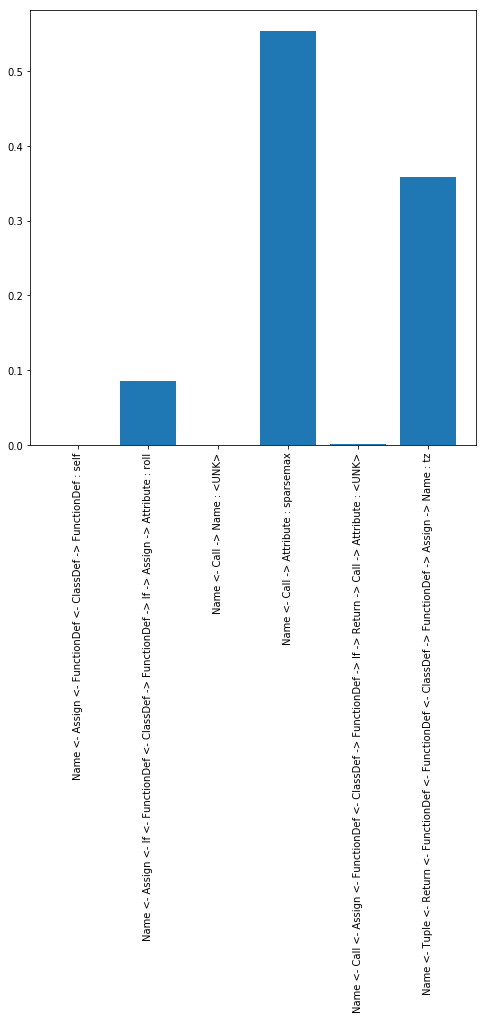

In [55]:
# import tensorflow as tf
# from matplotlib import pyplot as plt
j = 132
just_one = [ i[j:j+1] for i in data_tuple.test ]
paths = np.trim_zeros(just_one[2][0])
tvs = np.trim_zeros(just_one[3][0])
ptvs = translate_paths(paths, tvs)


path2idx, path2cnt = load_vocab('no_dups_1', 'quickload_paths')
tv2idx, tv2cnt = load_vocab('no_dups_1', 'quickload_tvs')
attention, translate = nn._feed_fwd(sess, just_one, [nn.attention_scores, nn.inference_id] )
# char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)


word_output = nn.translate(translate[0], do_join=False)
print(word_output)
# # print(np.trim_zeros(just_one[0][0]).shape)

attn = np.trim_zeros(attention[0])
plt.figure(figsize=(8,8))
_, c = attention.shape
plt.bar(np.arange(len(attn)), attn)
plt.xticks(np.arange(len(ptvs)), ptvs, rotation=90)
# plt.yticks(np.arange(len(word_output)), word_output)
# print(moved.shape)
plt.show()


In [14]:
# 10, 12, 23, 83, 192, 213, 237, 240, 247, 263, 
for i, t in enumerate(good_examples):
    print(i,t)

NameError: name 'good_examples' is not defined

In [ ]:
char_embeddings = nn.get_scope_variable(sess, 'embed_vars', 'char_embed')

In [ ]:
len(data_tuple.test[-1])


In [ ]:
#"\n".join("\t".join([str(j) for j in i]) for i in char_embeddings[0]) 
print("\n".join(["Char"] + [nn.idx2char[i] for i in sorted(nn.idx2char.keys())]))
